In [68]:
import pandas as pd
import os
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

### Veri Yükleme

In [69]:

camp_desc = pd.read_csv("../datasets/raw/campaign_desc.csv")
camp_table = pd.read_csv("../datasets/raw/campaign_table.csv")
causal_data = pd.read_csv("../datasets/raw/causal_data.csv")
coupon_redempt = pd.read_csv("../datasets/raw/coupon_redempt.csv")
coupon = pd.read_csv("../datasets/raw/coupon.csv")
hh_demographic = pd.read_csv("../datasets/raw/hh_demographic.csv")
product = pd.read_csv("../datasets/raw/product.csv")
transaction = pd.read_csv("../datasets/raw/transaction_data.csv")

In [70]:
data_list = [camp_desc, camp_table, causal_data, coupon_redempt, coupon, hh_demographic, product, transaction]

In [71]:
camp_table

,DESCRIPTION,household_key,CAMPAIGN
0,TypeA,17,26
1,TypeA,27,26
2,TypeA,212,26
3,TypeA,208,26
4,TypeA,192,26
...,...,...,...
7203,TypeC,1803,15
7204,TypeC,1082,15
7205,TypeC,942,15
7206,TypeC,855,15


In [72]:
def normalize_cols(df):
    df.columns = (df.columns
        .str.strip().str.lower()
        .str.replace(r"[^a-z0-9]+", "_", regex=True)   
        .str.replace(r"_+", "_", regex=True)           
        .str.strip("_")                                
    )


In [73]:
for data in data_list: 
    data = normalize_cols(data)

In [74]:
product.head() 

,product_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,
3,26190,69,GROCERY,Private,FRUIT - SHELF STABLE,APPLE SAUCE,50 OZ
4,26355,69,GROCERY,Private,COOKIES/CONES,SPECIALTY COOKIES,14 OZ


In [75]:
hh_demographic.rename(columns={"household_key": "household_id"}, inplace=True)   
camp_table.rename(columns={"household_key": "household_id"}, inplace=True)
camp_desc.rename(columns={"campaign": "campaign_id"}, inplace=True)
camp_table.rename(columns={"campaign": "campaign_id"}, inplace=True)
coupon_redempt.rename(columns={"campaign": "campaign_id"}, inplace=True)
coupon.rename(columns={"campaign": "campaign_id"}, inplace=True)
transaction.rename(columns={"household_key": "household_id"}, inplace=True)
coupon_redempt.rename(columns={"household_key": "household_id"}, inplace=True)

In [76]:
if "household_id" in hh_demographic:  # unique oldugunu soyleyebliriz. FK olarak kullanılabilir.
    print("unique household_id oranı (hh):", hh_demographic["household_id"].nunique()/len(hh_demographic))

unique household_id oranı (hh): 1.0


In [77]:
if "campaign_id" in hh_demographic:
    print("unique campaign_id oranı (camp):", hh_demographic["campaign_id"].nunique()/len(hh_demographic))

### EDA

In [78]:
import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 140)

dfs = {
    "hh_demographic": hh_demographic,
    "product": product,
    "campaign_desc": camp_desc,
    "coupon": coupon,
    "coupon_redempt": coupon_redempt,
    "campaign_table": camp_table,
    "transaction_data": transaction,
    "causal_data": causal_data
}

In [79]:
data_list = [camp_desc, camp_table, causal_data, coupon_redempt, coupon, hh_demographic, product, transaction]

In [80]:
basket_fact = (dfs["transaction_data"]
               .groupby(["household_id","basket_id","day"], as_index=False)
               .agg(
                   n_items=("product_id","count"),
                   qty=("quantity","sum"),
                   sales=("sales_value","sum"),
                   retail_disc=("retail_disc","sum"),
                   coupon_disc=("coupon_disc","sum"),
                   coupon_match_disc=("coupon_match_disc","sum")
               ))
display(basket_fact.head())


,household_id,basket_id,day,n_items,qty,sales,retail_disc,coupon_disc,coupon_match_disc
0,1,27601281299,51,30,34,78.66,-16.54,-1.0,0.0
1,1,27774192959,67,12,14,41.10,-8.59,0.0,0.0
2,1,28024266849,88,12,13,26.90,-6.72,0.0,0.0
3,1,28106322445,94,23,32,63.43,-11.08,-1.5,-0.5
4,1,28235481967,101,17,20,53.45,-16.42,0.0,0.0


### Hanelerin Siparişlerinin İncelenmesi

* Her hanenin toplam harcaması, sepet sayısı ve ortalama sepet tutarları

In [81]:
transaction.head()

,household_id,basket_id,day,product_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


In [82]:
transaction.groupby("household_id").agg({"quantity": "sum"}).describe()

,quantity
count,2.500000e+03
mean,1.042742e+05
std,2.444561e+05
min,5.000000e+00
25%,7.700000e+02
50%,1.108450e+04
75%,8.764000e+04
max,4.479917e+06


In [83]:
t = dfs["transaction_data"][["household_id", "basket_id", "day", "sales_value"]].copy()

In [84]:
basket_sum = t.groupby("household_id").agg(
    total_sales=("sales_value", "sum"),
    basket_count=("basket_id", "nunique")
).reset_index() # household_key'i tekrar sütun yapmak için

In [85]:
basket_sum 

,household_id,total_sales,basket_count
0,1,4330.16,86
1,2,1954.34,45
2,3,2653.21,47
3,4,1200.11,30
4,5,779.06,40
...,...,...,...
2495,2496,4339.66,63
2496,2497,7111.98,221
2497,2498,2601.60,172
2498,2499,3394.07,90


In [86]:
basket_sum["Avg_basket_size"] = basket_sum["total_sales"] / basket_sum["basket_count"]
basket_sum.head()

,household_id,total_sales,basket_count,Avg_basket_size
0,1,4330.16,86,50.350698
1,2,1954.34,45,43.429778
2,3,2653.21,47,56.451277
3,4,1200.11,30,40.003667
4,5,779.06,40,19.476500


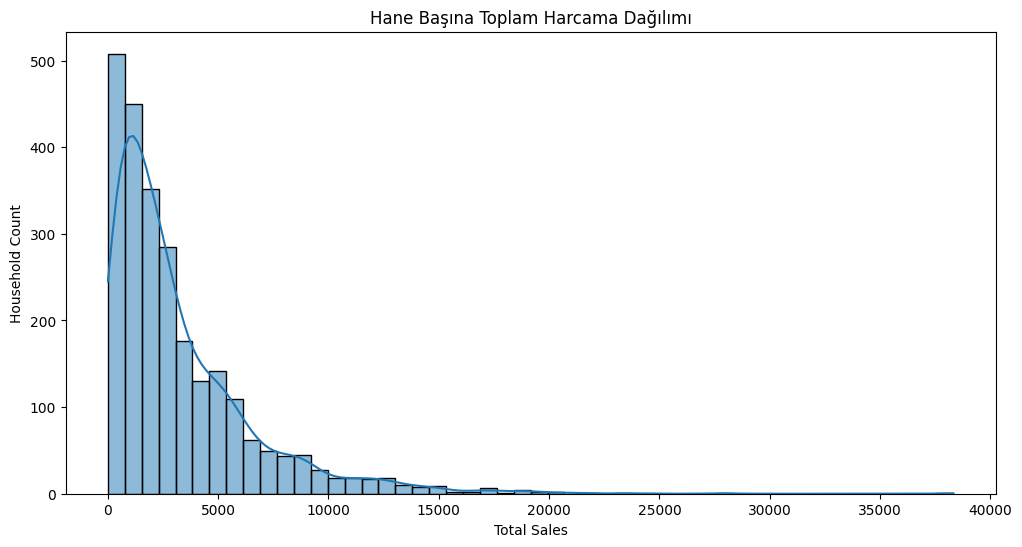

In [87]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 6))
sns.histplot(basket_sum["total_sales"], bins=50, kde=True)
plt.title("Hane Başına Toplam Harcama Dağılımı")
plt.xlabel("Total Sales")
plt.ylabel("Household Count")
plt.show()

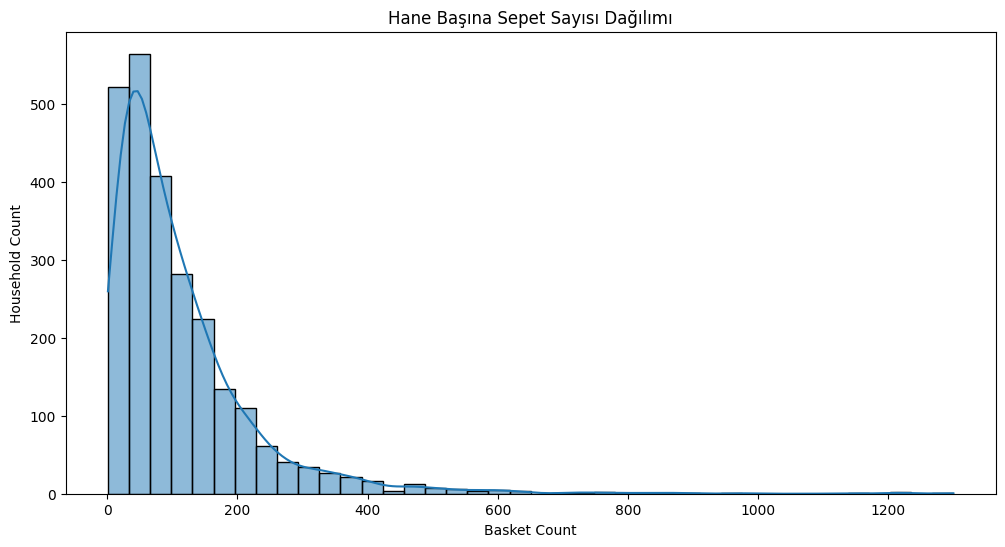

In [88]:
plt.figure(figsize=(12, 6))
sns.histplot(basket_sum["basket_count"], bins=40, kde=True)
plt.title("Hane Başına Sepet Sayısı Dağılımı")
plt.xlabel("Basket Count")
plt.ylabel("Household Count")
plt.show()

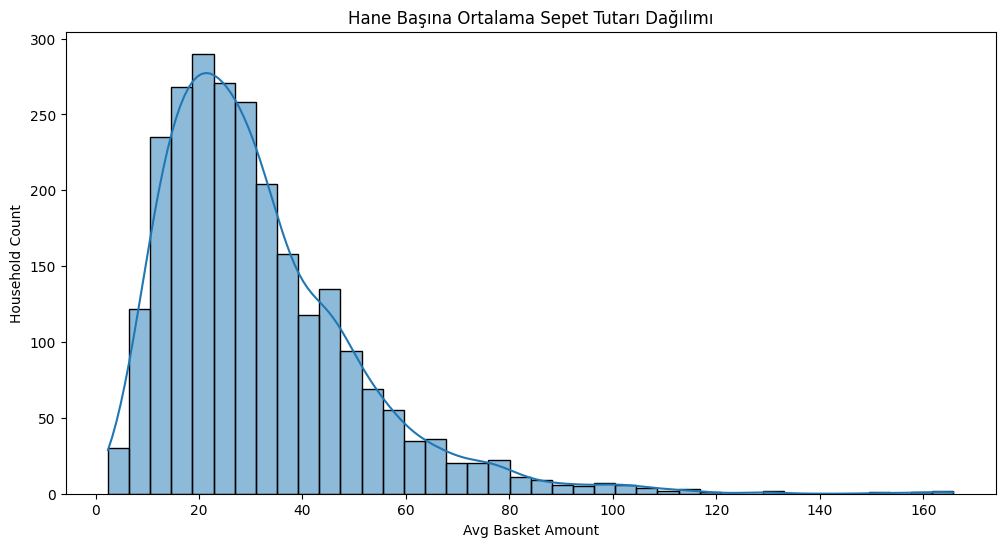

In [89]:
plt.figure(figsize=(12, 6))
sns.histplot(basket_sum["Avg_basket_size"], bins=40, kde=True)
plt.title("Hane Başına Ortalama Sepet Tutarı Dağılımı")
plt.xlabel("Avg Basket Amount" )
plt.ylabel("Household Count")
plt.show()

### Değişkenler Arası İlişkiler

* Alışveriş Sıklığı vs Toplam Harcama

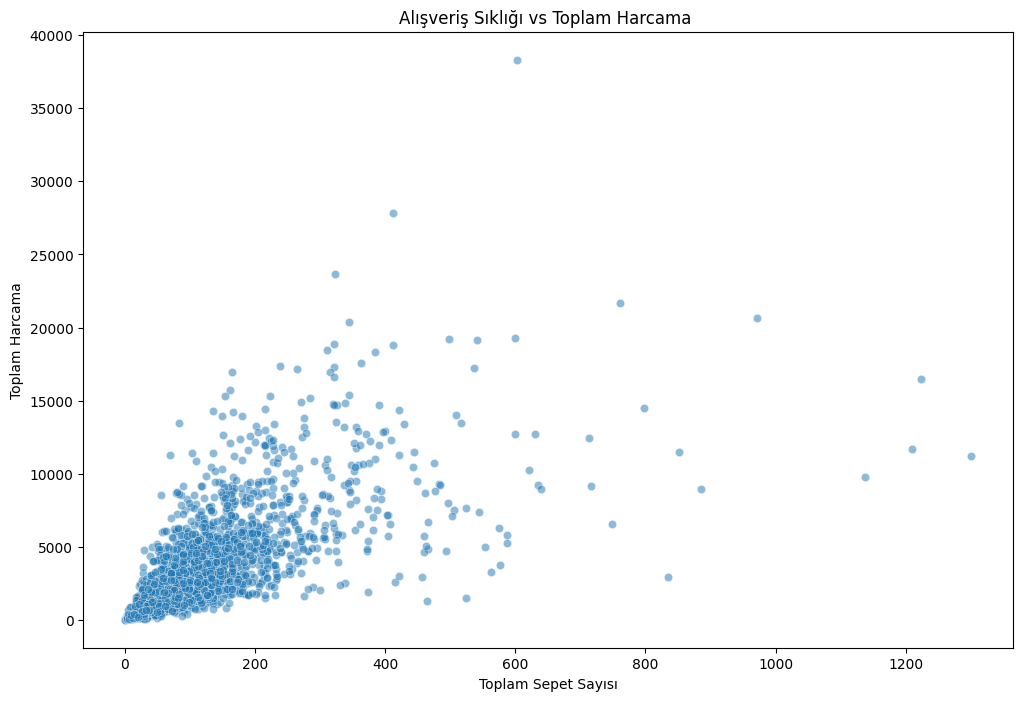

In [90]:
plt.figure(figsize=(12, 8))
sns.scatterplot(data=basket_sum, x="basket_count", y="total_sales", alpha=0.5)
plt.title("Alışveriş Sıklığı vs Toplam Harcama ")
plt.xlabel("Toplam Sepet Sayısı")
plt.ylabel("Toplam Harcama")
plt.show()

In [91]:
basket_sum

,household_id,total_sales,basket_count,Avg_basket_size
0,1,4330.16,86,50.350698
1,2,1954.34,45,43.429778
2,3,2653.21,47,56.451277
3,4,1200.11,30,40.003667
4,5,779.06,40,19.476500
...,...,...,...,...
2495,2496,4339.66,63,68.883492
2496,2497,7111.98,221,32.180905
2497,2498,2601.60,172,15.125581
2498,2499,3394.07,90,37.711889


* Ortalama Sepet Tutarı vs Toplam Harcama

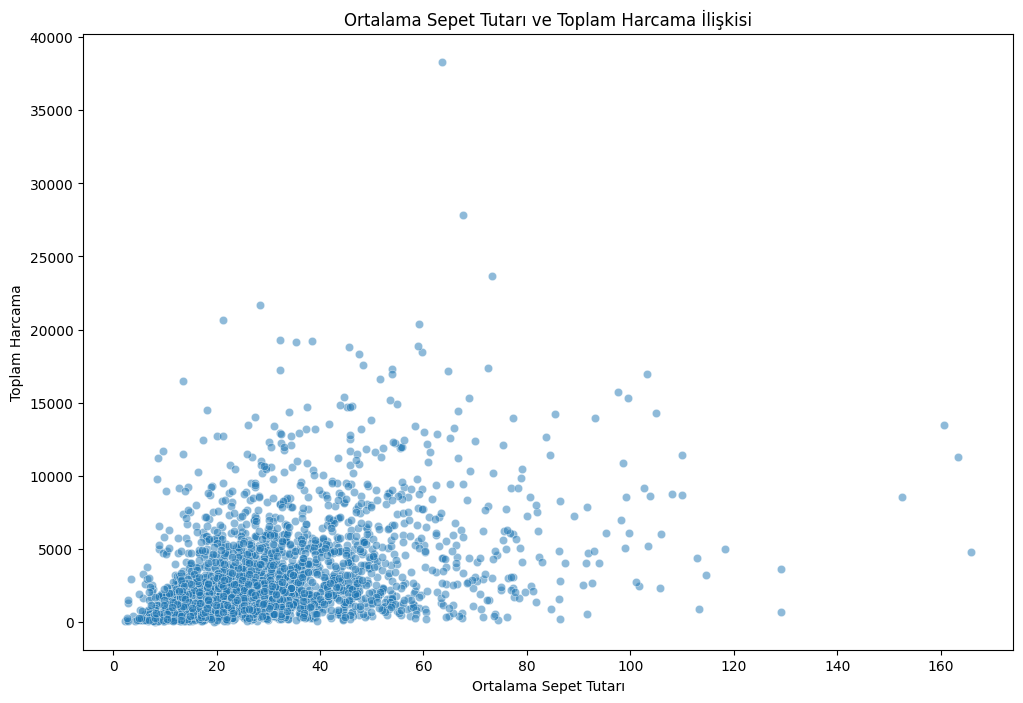

In [92]:
plt.figure(figsize=(12, 8))
sns.scatterplot(data=basket_sum, x="Avg_basket_size", y="total_sales", alpha=0.5)
plt.title("Ortalama Sepet Tutarı ve Toplam Harcama İlişkisi")
plt.xlabel("Ortalama Sepet Tutarı")
plt.ylabel("Toplam Harcama")
plt.show()

### Basit Müşteri Segmentasyonu

In [93]:
print(basket_sum["total_sales"].describe()) 

count     2500.000000
mean      3222.985232
std       3349.026076
min          8.170000
25%        970.740000
50%       2157.750000
75%       4413.320000
max      38319.790000
Name: total_sales, dtype: float64


Müşterileri toplam harcamalarına göre 4 farklı kategoriye ayırabiliriz.

In [94]:
bins = [0, 1000, 2500, 5000, np.inf]

In [95]:
labels = ["Low", "Avg", "High", "VIP"]

In [96]:
basket_sum["segment"] = pd.cut(basket_sum["total_sales"], bins=bins, labels=labels)

In [97]:
basket_sum

,household_id,total_sales,basket_count,Avg_basket_size,segment
0,1,4330.16,86,50.350698,High
1,2,1954.34,45,43.429778,Avg
2,3,2653.21,47,56.451277,High
3,4,1200.11,30,40.003667,Avg
4,5,779.06,40,19.476500,Low
...,...,...,...,...,...
2495,2496,4339.66,63,68.883492,High
2496,2497,7111.98,221,32.180905,VIP
2497,2498,2601.60,172,15.125581,High
2498,2499,3394.07,90,37.711889,High


### Join işlemleri

In [98]:
segment_profile_df = pd.merge(basket_sum, hh_demographic, on="household_id", how="inner")

In [99]:
segment_profile_df.head()

,household_id,total_sales,basket_count,Avg_basket_size,segment,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,1,4330.16,86,50.350698,High,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown
1,7,3400.05,59,57.627966,High,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown
2,8,5534.97,113,48.982035,VIP,25-34,U,25-34K,Unknown,2 Adults Kids,3,1
3,13,13190.92,275,47.966982,VIP,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2
4,16,1512.02,98,15.428776,Avg,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown


* Harcama segmentlerine göre gelir durumu 

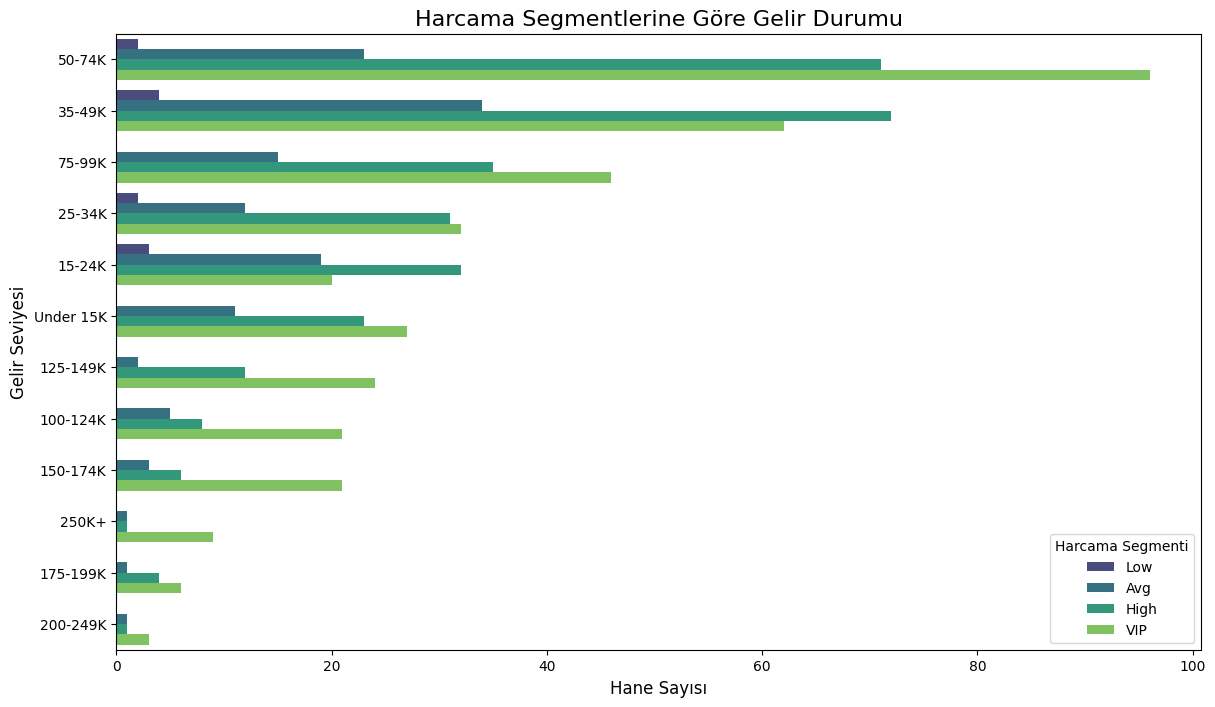

In [100]:
plt.figure(figsize=(14, 8))
sns.countplot(data=segment_profile_df, 
              y="income_desc", 
              hue="segment", 
              order=segment_profile_df["income_desc"].value_counts().index,
              palette="viridis")
plt.title("Harcama Segmentlerine Göre Gelir Durumu", fontsize=16)
plt.xlabel("Hane Sayısı", fontsize=12)
plt.ylabel("Gelir Seviyesi", fontsize=12)
plt.legend(title="Harcama Segmenti")
plt.show()

### İki Boyutlu Segmentasyon

In [101]:
basket_sum["frequency_segment"] = pd.qcut(basket_sum["basket_count"], 
                                          q=4, 
                                          labels=["Rare", "Occasional", "Frequent", "Very Frequent"])

In [102]:
basket_sum["overall_segment"] = basket_sum["segment"].astype(str) + ' - ' + basket_sum["frequency_segment"].astype(str)


In [103]:
basket_sum.head()

,household_id,total_sales,basket_count,Avg_basket_size,segment,frequency_segment,overall_segment
0,1,4330.16,86,50.350698,High,Frequent,High - Frequent
1,2,1954.34,45,43.429778,Avg,Occasional,Avg - Occasional
2,3,2653.21,47,56.451277,High,Occasional,High - Occasional
3,4,1200.11,30,40.003667,Avg,Rare,Avg - Rare
4,5,779.06,40,19.476500,Low,Occasional,Low - Occasional


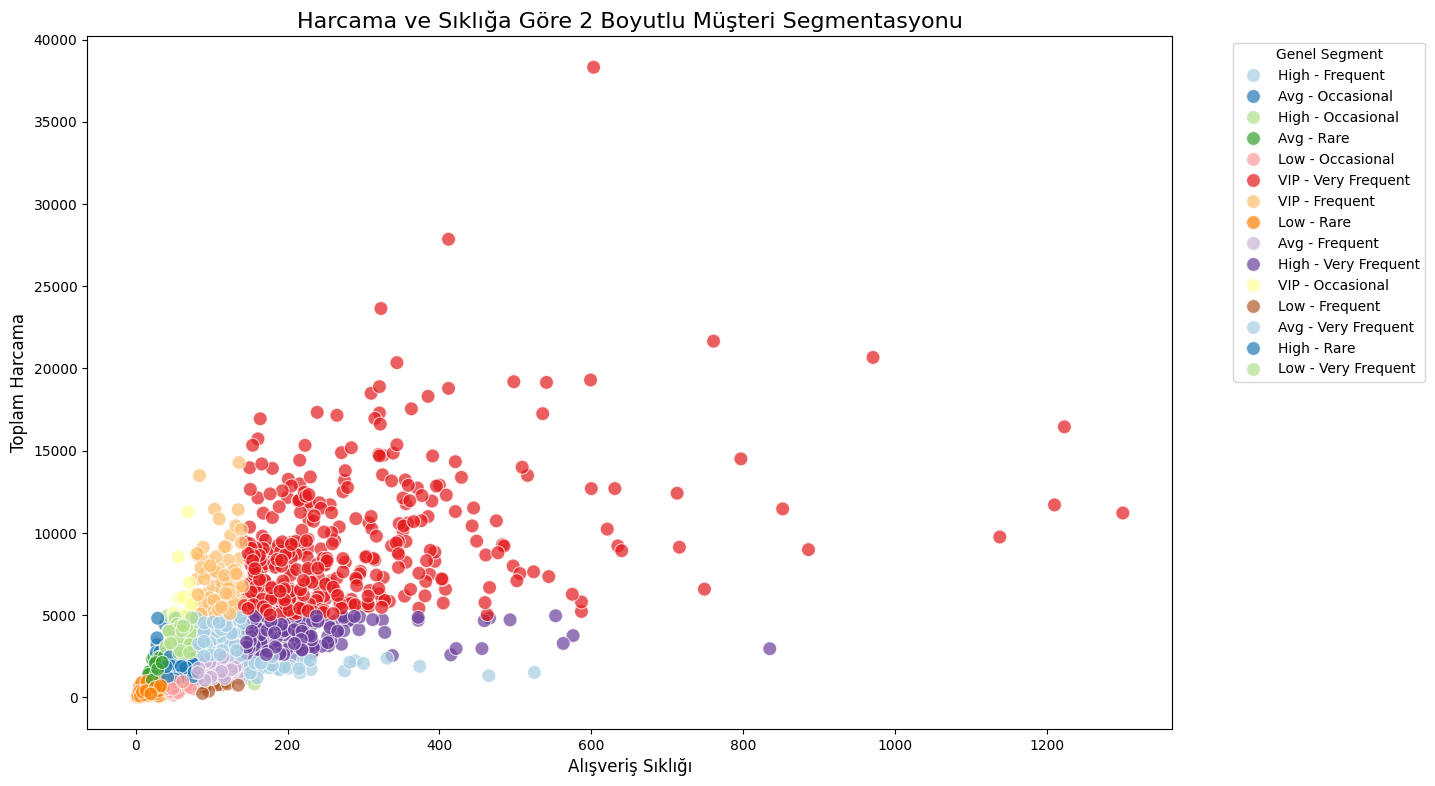

In [104]:
plt.figure(figsize=(14, 9))
sns.scatterplot(data=basket_sum, 
                x="basket_count", 
                y="total_sales", 
                hue="overall_segment", 
                palette="Paired",
                alpha=0.7,
                s=100) 
plt.title("Harcama ve Sıklığa Göre 2 Boyutlu Müşteri Segmentasyonu", fontsize=16)
plt.xlabel("Alışveriş Sıklığı", fontsize=12)
plt.ylabel("Toplam Harcama" , fontsize=12)
plt.legend(title="Genel Segment", bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

### Segmentlere Göre Ürün Tercihlerini Analiz Etme

In [105]:
trans_with_segment = pd.merge(transaction, basket_sum[["household_id", "segment"]], on="household_id", how='left')

In [106]:
full_df = pd.merge(trans_with_segment, product, on="product_id", how="left")

Vip kategorisi için

In [107]:
vip_customers = full_df[full_df["segment"] == "VIP"]
top_departments_vip = vip_customers.groupby("department")["sales_value"].sum().nlargest(10)

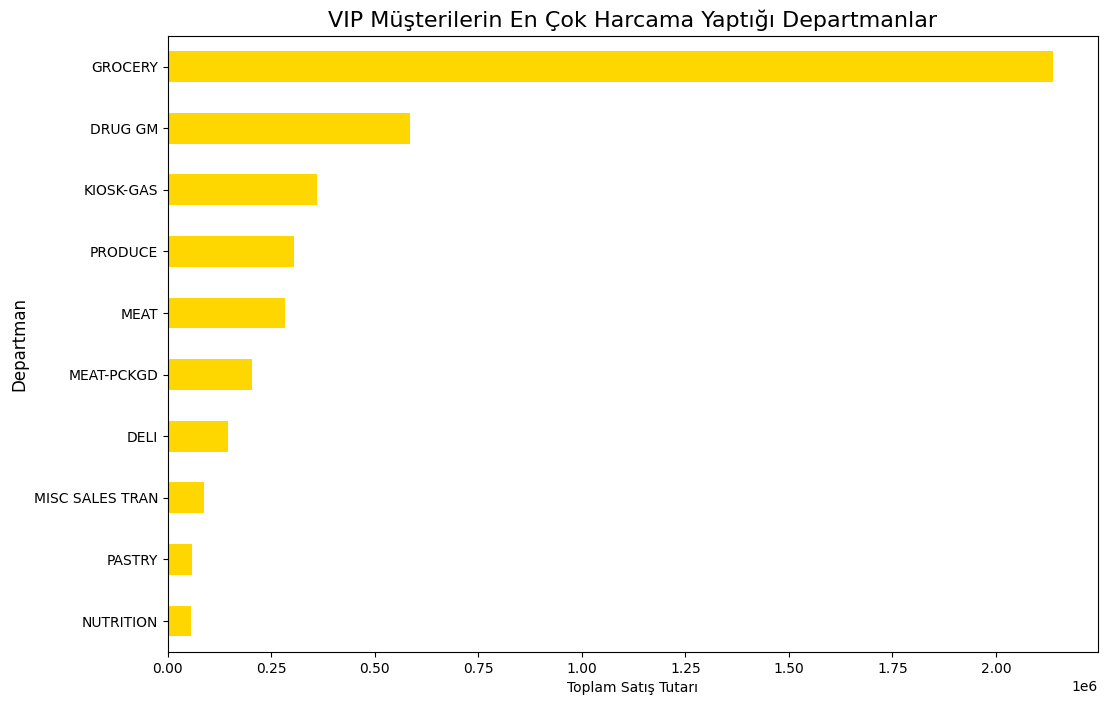

In [108]:
plt.figure(figsize=(12, 8))
top_departments_vip.sort_values().plot(kind="barh", color="gold")
plt.title("VIP Müşterilerin En Çok Harcama Yaptığı Departmanlar", fontsize=16)
plt.xlabel("Toplam Satış Tutarı", fontsize=10)
plt.ylabel("Departman", fontsize=12)
plt.show()

###  Adding more features

In [109]:
transaction.head()

,household_id,basket_id,day,product_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


In [110]:
analysis_day = transaction["day"].max()

Finding last purchase day for all customers

In [111]:
last_purchase_df = transaction.groupby("household_id")["day"].max().reset_index()

In [112]:
last_purchase_df.rename(columns={"day": "last_purchase_day"}, inplace=True)

In [113]:
last_purchase_df.head()

,household_id,last_purchase_day
0,1,706
1,2,668
2,3,703
3,4,627
4,5,703


* Determining the Recency Value


In [114]:
last_purchase_df["last_purchase_day"] = analysis_day - last_purchase_df["last_purchase_day"]

In [115]:
last_purchase_df.head()

,household_id,last_purchase_day
0,1,5
1,2,43
2,3,8
3,4,84
4,5,8


In [116]:
basket_sum_updated = pd.merge(basket_sum, last_purchase_df[['household_id', 'last_purchase_day']], on='household_id', how='left')


In [117]:
basket_sum_updated.head()

,household_id,total_sales,basket_count,Avg_basket_size,segment,frequency_segment,overall_segment,last_purchase_day
0,1,4330.16,86,50.350698,High,Frequent,High - Frequent,5
1,2,1954.34,45,43.429778,Avg,Occasional,Avg - Occasional,43
2,3,2653.21,47,56.451277,High,Occasional,High - Occasional,8
3,4,1200.11,30,40.003667,Avg,Rare,Avg - Rare,84
4,5,779.06,40,19.476500,Low,Occasional,Low - Occasional,8


#### Adding demographic features 

In [118]:
hh_demographic.head()

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,household_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8
3,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2,13
4,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,16


In [119]:
customer_features_df = pd.merge(basket_sum_updated, hh_demographic, on="household_id", how="left")

In [120]:
customer_features_df.tail()

,household_id,total_sales,basket_count,Avg_basket_size,segment,frequency_segment,overall_segment,last_purchase_day,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
2495,2496,4339.66,63,68.883492,High,Occasional,High - Occasional,28,45-54,A,75-99K,Homeowner,Unknown,3,1
2496,2497,7111.98,221,32.180905,VIP,Very Frequent,VIP - Very Frequent,11,45-54,U,35-49K,Unknown,Single Male,1,None/Unknown
2497,2498,2601.60,172,15.125581,High,Very Frequent,High - Very Frequent,1,25-34,U,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown
2498,2499,3394.07,90,37.711889,High,Frequent,High - Frequent,2,25-34,U,Under 15K,Unknown,2 Adults Kids,3,1
2499,2500,5486.16,113,48.550088,VIP,Frequent,VIP - Frequent,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Coupon Features

In [121]:
discount_features = transaction.groupby("household_id").agg({
    "retail_disc": lambda x: x.abs().sum(),
    "coupon_disc" : lambda x: x.abs().sum()
}).reset_index()

In [122]:
discount_features.rename(columns={"retail_disc": "total_retail_disc", "coupon_disc": "total_coupon_disc"}, inplace=True)

In [123]:
discount_features["total_discount"] = discount_features["total_retail_disc"] + discount_features["total_coupon_disc"]

In [124]:
coupon_usage = coupon_redempt.groupby("household_id").size().reset_index(name="total_coupons_redeemed")

In [131]:
customer_features_df = pd.merge(customer_features_df, discount_features, on="household_id", how="left")

In [132]:
customer_features_df = pd.merge(customer_features_df, coupon_usage[["household_id", "total_coupons_redeemed"]], on="household_id", how="left")

In [133]:
customer_features_df["total_discount"].fillna(0, inplace=True)
customer_features_df["total_coupons_redeemed"].fillna(0, inplace=True)

C:\Users\fatih\AppData\Local\Temp\ipykernel_18768\3548567912.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  customer_features_df["total_discount"].fillna(0, inplace=True)
C:\Users\fatih\AppData\Local\Temp\ipykernel_18768\3548567912.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a 

In [134]:
customer_features_df.isnull().sum()

household_id                   0
total_sales                    0
basket_count                   0
Avg_basket_size                0
segment                        0
frequency_segment              0
overall_segment                0
last_purchase_day              0
age_desc                    1699
marital_status_code         1699
income_desc                 1699
homeowner_desc              1699
hh_comp_desc                1699
household_size_desc         1699
kid_category_desc           1699
total_coupons_redeemed_x    2066
total_coupons_redeemed_y    2066
total_retail_disc              0
total_coupon_disc              0
total_discount                 0
total_coupons_redeemed         0
dtype: int64

* Discount ratio for total sales

In [136]:
customer_features_df["discount_ratio"] = (customer_features_df["total_discount"] / customer_features_df["total_sales"]).fillna(0)

In [137]:
customer_features_df.head()

,household_id,total_sales,basket_count,Avg_basket_size,segment,frequency_segment,overall_segment,last_purchase_day,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,total_coupons_redeemed_x,total_coupons_redeemed_y,total_retail_disc,total_coupon_disc,total_discount,total_coupons_redeemed,discount_ratio
0,1,4330.16,86,50.350698,High,Frequent,High - Frequent,5,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,5.0,5.0,697.04,80.56,777.60,5.0,0.179578
1,2,1954.34,45,43.429778,Avg,Occasional,Avg - Occasional,43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,334.99,9.00,343.99,0.0,0.176013
2,3,2653.21,47,56.451277,High,Occasional,High - Occasional,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,675.16,61.19,736.35,0.0,0.277532
3,4,1200.11,30,40.003667,Avg,Rare,Avg - Rare,84,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,115.65,2.50,118.15,0.0,0.098449
4,5,779.06,40,19.476500,Low,Occasional,Low - Occasional,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,118.33,0.00,118.33,0.0,0.151888
